In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
from environment import LinearBanditEnv
from oracles import StatisticalAEOracle
from agent import QSOFULAgent

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# If you updated oracles, import the right class name here.
from oracles import StatisticalAEOracle, ClassicalOracle
from environment import LinearBanditEnv
from agent import QSOFULAgent


In [2]:
# --- Configuration ---
N_CORES = -1      # Use all available CPU cores
N_TRIALS = 30     # High number of trials to smooth out the "zig-zag" noise
Q_TOTAL = 1e5     # Horizon for sweeps
SEED_OFFSET = 47

# --- Core Runner (Same as before) ---
def run_single_trial(d, s_star, Q_total, seed):
    """
    Runs one instance of Q-SOFUL.
    """
    rng_env = np.random.default_rng(seed)
    oracle = StatisticalAEOracle(rng=rng_env)
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    # Different seed for agent to avoid correlation
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed+999)
    
    total_queries = 0
    cumulative_regret = 0.0
    
    while total_queries < Q_total:
        eps_k, delta_k, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()
        
        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError:
            break
            
        agent.update_model(x_played, y_hat)
        
        # Regret Calculation
        # Regret Calculation (use safe-set optimum)
        val_opt = np.linalg.norm(env.theta_star, 1)
        val_played = env.true_reward(x_played)
        epoch_regret = cost * max(0.0, val_opt - val_played)

        
        cumulative_regret += epoch_regret
        total_queries += cost
        
    return cumulative_regret

# --- Parallel Helper ---
def run_point_parallel(d, s_star, Q_total, n_trials):
    """
    Runs N_TRIALS in parallel for a specific (d, s*) configuration.
    Returns mean and std of final regret.
    """
    seeds = [SEED_OFFSET + i for i in range(n_trials)]
    
    # Execute in parallel
    results = Parallel(n_jobs=N_CORES)(
        delayed(run_single_trial)(d, s_star, Q_total, seed) for seed in seeds
    )
    
    return np.mean(results), np.std(results)

# --- Sweep 1: Fine-Grained Dimension Grid ---
def run_fine_dim_sweep():
    print(f"\n--- 1. Massive Dimension Sweep (Trials={N_TRIALS}) ---")
    s_star = 3
    # Log-spaced grid to capture the log(d) behavior nicely
    # 20, 30, 50, 80, 130, 200, 300, 500, 800, 1000
    d_values = np.unique(np.logspace(np.log10(20), np.log10(1000), num=12).astype(int))
    
    means = []
    stds = []
    
    for d in d_values:
        start = time.time()
        mu, sigma = run_point_parallel(d, s_star, Q_TOTAL, N_TRIALS)
        means.append(mu)
        stds.append(sigma)
        print(f"  d={d:4d} | Regret={mu:.0f} ± {sigma:.0f} | Time={time.time()-start:.1f}s")
        
    return d_values, np.array(means), np.array(stds)

# --- Sweep 2: Fine-Grained Sparsity Grid ---
def run_fine_sparsity_sweep():
    print(f"\n--- 2. Massive Sparsity Sweep (Trials={N_TRIALS}) ---")
    d = 200
    # Linear grid 1 to 15
    s_values = np.arange(1, 30, 2) 
    
    means = []
    stds = []
    
    for s_star in s_values:
        start = time.time()
        mu, sigma = run_point_parallel(d, s_star, Q_TOTAL, N_TRIALS)
        means.append(mu)
        stds.append(sigma)
        print(f"  s*={s_star:2d} | Regret={mu:.0f} ± {sigma:.0f} | Time={time.time()-start:.1f}s")
        
    return s_values, np.array(means), np.array(stds)

# --- Plotting ---
def plot_results(dim_data, sparse_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Dimension
    d_vals, d_mean, d_std = dim_data
    axs[0].plot(d_vals, d_mean, 'o-', color='navy', linewidth=2, label='Mean Regret')
    axs[0].fill_between(d_vals, d_mean - d_std, d_mean + d_std, color='navy', alpha=0.15, label='±1 Std Dev')
    
    # Theoretical curve overlay: A * sqrt(log d) + B
    # Fit strictly to show scaling shape
    log_d = np.sqrt(np.log(d_vals))
    # Simple least squares fit
    A = np.polyfit(log_d, d_mean, 1)[0]
    B = np.polyfit(log_d, d_mean, 1)[1]
    axs[0].plot(d_vals, A * log_d + B, 'r--', linewidth=2, label=r'Fit: $\propto \sqrt{\log d}$')
    
    axs[0].set_title(f'Dimension Independence Test (Trials={N_TRIALS})', fontsize=14)
    axs[0].set_xlabel('Dimension $d$ (Log Scale)', fontsize=12)
    axs[0].set_ylabel('Cumulative Regret', fontsize=12)
    axs[0].set_xscale('log')
    axs[0].grid(True, which="both", ls="-", alpha=0.2)
    axs[0].legend()
    
    # Plot 2: Sparsity
    s_vals, s_mean, s_std = sparse_data
    axs[1].plot(s_vals, s_mean, 's-', color='darkgreen', linewidth=2, label='Mean Regret')
    axs[1].fill_between(s_vals, s_mean - s_std, s_mean + s_std, color='darkgreen', alpha=0.15, label='±1 Std Dev')
    
    # Theoretical curve: Linear
    A_s = np.polyfit(s_vals, s_mean, 1)[0]
    B_s = np.polyfit(s_vals, s_mean, 1)[1]
    axs[1].plot(s_vals, A_s * s_vals + B_s, 'r--', linewidth=2, label=r'Fit: $\propto s^*$')
    
    axs[1].set_title(f'Sparsity Dependence Test (d=200)', fontsize=14)
    axs[1].set_xlabel('Sparsity $s^*$', fontsize=12)
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [3]:
# if __name__ == "__main__":
#     d_data = run_fine_dim_sweep()
#     s_data = run_fine_sparsity_sweep()
#     plot_results(d_data, s_data)

In [4]:
# --- Helper: Detailed Trial Runner ---
def run_detailed_trial(config):
    d = config['d']
    s_star = config['s_star']
    Q_total = config['Q_total']
    sigma_p = config.get('sigma_p', 0.5)
    oracle_type = config.get('oracle_type', 'quantum')
    seed = config['seed']

    # NEW: smoothing params (defaults chosen to actually explore)
    gamma = config.get('gamma', 0.02)
    M = config.get('M', gamma)  # must satisfy M <= gamma
    alpha_scale = config.get('alpha_scale', 0.25)

    rng_env = np.random.default_rng(seed)

    # Select Oracle
    if oracle_type == 'classical':
        oracle = ClassicalOracle(rng=rng_env)
    else:
        oracle = StatisticalAEOracle(rng=rng_env)

    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)

    # NEW: pass gamma/M/sigma_p/alpha_scale through constructor (for updated agent.py)
    agent = QSOFULAgent(
        d=d,
        s_star=s_star,
        delta_tot=0.01,
        Q_total=Q_total,
        seed=seed + 999,
        gamma=gamma,
        M=M,
        sigma_p=sigma_p,
    )

    history = {'queries': [0], 'regret': [0.0]}

    total_queries = 0
    cum_regret = 0.0

    while total_queries < Q_total:
        eps_k, delta_k, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()

        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError:
            break

        agent.update_model(x_played, y_hat)

        # --- Regret (PATCHED): use safe-set optimum ---
       # --- Regret (Option A): compare to full action set [-1,1]^d ---
        val_opt = np.linalg.norm(env.theta_star, 1)     # full-set optimum
        val_played = env.true_reward(x_played)

        epoch_regret = cost * max(0.0, val_opt - val_played)
        cum_regret += epoch_regret

        total_queries += cost

        history['queries'].append(total_queries)
        history['regret'].append(cum_regret)

    return history

In [5]:

# --- Experiment: Massive Scale Quantum vs Classical ---
def run_quantum_advantage_massive(n_trials=12):
    LARGE_HORIZON = 1e8

    print(f"Running Massive Scale Experiment (Q_total={LARGE_HORIZON:.0e})...")

    # Common Config
    base_config = {
        'd': 100,
        's_star': 5,
        'Q_total': LARGE_HORIZON,
        'sigma_p': 0.05,      # (only matters for trunc_gaussian; safe to keep)
        'gamma': 0.02,        # NEW: not 1/Q_total
        'M': 0.02,            # NEW: must be <= gamma
        'alpha_scale': 0.25,  # NEW: prevents “all zeros” Lasso in finite sims
    }

    seeds = range(5000, 5000 + n_trials)

    print("  1. Simulating Quantum Agents...")
    res_q = Parallel(n_jobs=-1)(
        delayed(run_detailed_trial)({**base_config, 'oracle_type': 'quantum', 'seed': s})
        for s in seeds
    )

    print("  2. Simulating Classical Agents...")
    res_c = Parallel(n_jobs=-1)(
        delayed(run_detailed_trial)({**base_config, 'oracle_type': 'classical', 'seed': s})
        for s in seeds
    )

    # Interpolation for clean averaging
    q_grid = np.geomspace(50000, LARGE_HORIZON, 500)
    reg_q_avg = np.zeros_like(q_grid)
    reg_c_avg = np.zeros_like(q_grid)

    def get_interp(grid, res):
        x = res['queries']
        y = res['regret']
        return np.interp(grid, x, y)

    for r in res_q:
        reg_q_avg += get_interp(q_grid, r) / n_trials
    for r in res_c:
        reg_c_avg += get_interp(q_grid, r) / n_trials

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(q_grid, reg_c_avg, 'r--', label=r'Classical ($Cost \propto 1/\epsilon^2$)', lw=3, alpha=0.8)
    plt.plot(q_grid, reg_q_avg, 'b-', label=r'Q-SOFUL ($Cost \propto 1/\epsilon$)', lw=3)

    plt.xlabel('Total Queries (Log Scale)', fontsize=12)
    plt.ylabel('Cumulative Regret', fontsize=12)
    plt.title(f'Exponential Speedup Demonstration (Horizon={LARGE_HORIZON:.0e})', fontsize=14)
    plt.legend(fontsize=12)

    plt.grid(True, which="major", ls="-", alpha=0.4)
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    plt.xscale('log')
    # plt.yscale('log')
    plt.tight_layout()
    plt.show()


In [6]:
# run_quantum_advantage_massive()

In [51]:

base = {
    "d": 100,
    "s_star": 5,
    "Q_total": int(1e7),
    "sigma_p": 0.1,
    "oracle_type": "quantum",
    "gamma": 0.06,
    "M": 0.04,
    "log_every": 1,
    'alpha_scale': 1,
    # drop tau entirely if you switch to top-k support
    }

def run_convergence_experiment(
    n_trials=12,
    Q_total=1e8,
    d=100,
    s_star=5,
    sigma_p=0.05,
    gamma=0.06,
    M=0.04,
    oracle_type="quantum",
    n_grid=200,
    grid_mode="min",   # "min" avoids fake plateaus from np.interp extrapolation
    backend="threading"
):
    """
    Convergence plot using regret curves returned by run_detailed_trial(config).

    Key patch: we ONLY plot up to a query horizon where runs actually have data,
    so you don't get a flat tail caused by interpolation beyond the last query.
    """
    print("Running Exp 1: Convergence (using regret curves from run_detailed_trial)...")

    base_config = {
        "d": d,
        "s_star": s_star,
        "Q_total": int(Q_total),
        "sigma_p": sigma_p,
        "oracle_type": oracle_type,
        "gamma": gamma,
        "M": M,
    }

    seeds = range(1000, 1000 + n_trials)

    # Run trials
    try:
        from joblib import parallel_backend
        with parallel_backend(backend):
            results = Parallel(n_jobs=-1)(
                delayed(run_detailed_trial)({**base_config, "seed": s}) for s in seeds
            )
    except Exception:
        # fallback if parallel_backend isn't available in your session
        results = Parallel(n_jobs=-1)(
            delayed(run_detailed_trial)({**base_config, "seed": s}) for s in seeds
        )

    # Extract last query per run
    last_q = np.array([r["queries"][-1] for r in results if len(r.get("queries", [])) > 0], dtype=float)
    if last_q.size == 0:
        print("No valid runs (empty histories).")
        return None

    print("last query: min/median/max =", int(last_q.min()), float(np.median(last_q)), int(last_q.max()))

    # Choose plotting horizon to avoid extrapolation artifacts
    if grid_mode == "min":
        q_max = int(last_q.min())
    elif grid_mode == "p90":
        q_max = int(np.percentile(last_q, 90))
    elif grid_mode == "median":
        q_max = int(np.median(last_q))
    elif grid_mode == "max":
        q_max = int(last_q.max())
    else:
        raise ValueError("grid_mode must be one of: 'min','p90','median','max'")

    if q_max <= 0:
        print("q_max is non-positive; cannot plot.")
        return None

    query_grid = np.linspace(0, q_max, n_grid)

    # Average regret (no extrapolation because query_grid <= last_q for chosen q_max)
    reg_avg = np.zeros_like(query_grid, dtype=float)
    valid_runs = 0

    for r in results:
        x = np.asarray(r["queries"], dtype=float)
        y = np.asarray(r["regret"], dtype=float)
        if x.size < 2:
            continue
        reg_avg += np.interp(query_grid, x, y)
        valid_runs += 1

    if valid_runs == 0:
        print("No valid runs with >=2 points.")
        return None

    reg_avg /= valid_runs

    # Plot (NORMAL axes, not log-log)
    plt.figure(figsize=(8, 5))
    plt.plot(query_grid, reg_avg, lw=2, label=f"Avg regret ({valid_runs} runs)")
    plt.xlabel("Total Queries")
    plt.ylabel("Cumulative Regret")
    plt.title("Convergence: Cumulative Regret vs Queries")
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

    avg_reg_per_q = reg_avg / query_grid
    plt.figure(figsize=(8,5))
    plt.plot(query_grid, avg_reg_per_q, lw=2)
    plt.xlabel("Total Queries")
    plt.ylabel("Avg regret per query (R/Q)")
    plt.title("Learning check: does R/Q go to 0?")
    plt.grid(True, alpha=0.2)
    plt.show()


    return {
        "query_grid": query_grid,
        "reg_avg": reg_avg,
        "results": results,
        "last_q": last_q,
        "q_max_plotted": q_max,
        "valid_runs": valid_runs,
    }


Running Exp 1: Convergence (using regret curves from run_detailed_trial)...


/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-06, tolerance: 1.406e-06
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.153e-06, tolerance: 7.063e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

last query: min/median/max = 139030982 139030982.0 139030982


/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.817e-06, tolerance: 2.121e-06
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e-06, tolerance: 2.518e-06
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

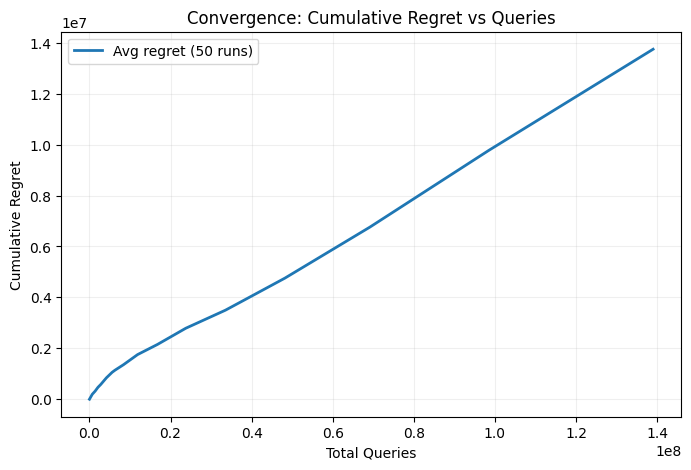

/var/folders/m4/rndkh84x7l7_zhb99lhzjcqw0000gn/T/ipykernel_37818/710159749.py:114: RuntimeWarning: invalid value encountered in divide
  avg_reg_per_q = reg_avg / query_grid


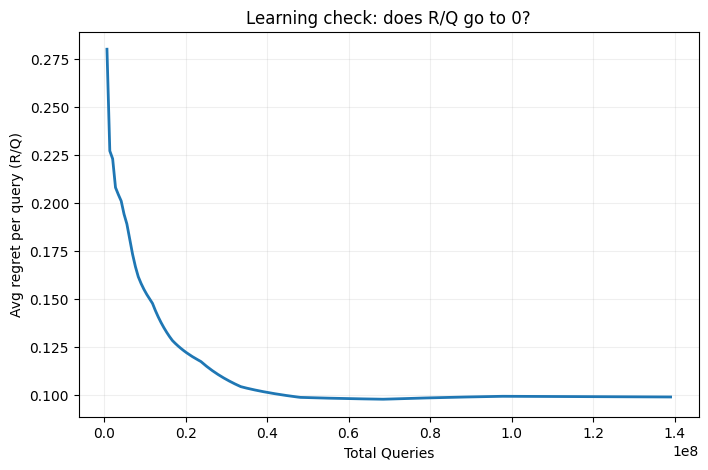

{'query_grid': array([0.00000000e+00, 6.98648151e+05, 1.39729630e+06, 2.09594445e+06,
        2.79459260e+06, 3.49324075e+06, 4.19188890e+06, 4.89053706e+06,
        5.58918521e+06, 6.28783336e+06, 6.98648151e+06, 7.68512966e+06,
        8.38377781e+06, 9.08242596e+06, 9.78107411e+06, 1.04797223e+07,
        1.11783704e+07, 1.18770186e+07, 1.25756667e+07, 1.32743149e+07,
        1.39729630e+07, 1.46716112e+07, 1.53702593e+07, 1.60689075e+07,
        1.67675556e+07, 1.74662038e+07, 1.81648519e+07, 1.88635001e+07,
        1.95621482e+07, 2.02607964e+07, 2.09594445e+07, 2.16580927e+07,
        2.23567408e+07, 2.30553890e+07, 2.37540371e+07, 2.44526853e+07,
        2.51513334e+07, 2.58499816e+07, 2.65486297e+07, 2.72472779e+07,
        2.79459260e+07, 2.86445742e+07, 2.93432223e+07, 3.00418705e+07,
        3.07405186e+07, 3.14391668e+07, 3.21378149e+07, 3.28364631e+07,
        3.35351112e+07, 3.42337594e+07, 3.49324075e+07, 3.56310557e+07,
        3.63297038e+07, 3.70283520e+07, 3.77270001

In [52]:
run_convergence_experiment(n_trials=50)
#run_smoothing_sweep(n_trials=20)

In [9]:
def run_theta_learning_trial(config):
    d = config['d']
    s_star = config['s_star']
    Q_total = int(config['Q_total'])
    seed = config['seed']
    sigma_p = config.get('sigma_p', 0.5)
    oracle_type = config.get('oracle_type', 'quantum')
    gamma = float(config.get('gamma', 0.02))
    M = float(config.get('M', gamma))
    tau = float(config.get('tau', 1e-3))          # threshold for support
    log_every = int(config.get('log_every', 1))   # log every epoch by default

    rng_env = np.random.default_rng(seed)
    oracle = ClassicalOracle(rng=rng_env) if oracle_type == 'classical' else StatisticalAEOracle(rng=rng_env)

    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed + 999)

    # enforce meaningful smoothing (avoid 1/Q_total defaults)
    agent.gamma = gamma
    agent.M = M
    agent.sigma_p = sigma_p

    theta_star = env.theta_star.copy()
    true_supp = set(np.where(np.abs(theta_star) > 0)[0].tolist())

    total_queries = 0
    epoch = 0

    history = {
        "queries": [],
        "l2": [],
        "l1": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "nnz": [],
        "theta_l1": [],
    }

    while total_queries < Q_total:
        epoch += 1
        eps_k, delta_k, _ = agent.prepare_epoch()
        _, x_played = agent.select_action()

        y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        agent.update_model(x_played, y_hat)
        total_queries += cost

        if epoch % log_every != 0:
            continue

        theta_hat = np.asarray(agent.hat_theta, dtype=float)
        diff = theta_hat - theta_star
        
        
        # diff = theta_hat - theta_star

        # l2 = float(np.linalg.norm(diff, 2))
        # l1 = float(np.linalg.norm(diff, 1))

        # est_supp = set(np.where(np.abs(theta_hat) > tau)[0].tolist())



        l2 = float(np.linalg.norm(diff, 2))
        l1 = float(np.linalg.norm(diff, 1))

        # Top-k support recovery (k = s_star)
        k = s_star
        est_supp = set(np.argsort(np.abs(theta_hat))[-k:].tolist())


        tp = len(true_supp & est_supp)
        fp = len(est_supp - true_supp)
        fn = len(true_supp - est_supp)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        history["queries"].append(total_queries)
        history["l2"].append(l2)
        history["l1"].append(l1)
        history["precision"].append(precision)
        history["recall"].append(recall)
        history["f1"].append(f1)
        history["nnz"].append(int(np.sum(np.abs(theta_hat) > tau)))
        history["theta_l1"].append(float(np.linalg.norm(theta_hat, 1)))

    return history


In [32]:
def run_theta_learning_experiment(n_trials=10):

    # base = {
    # "d": 100,
    # "s_star": 10,
    # "Q_total": int(1e10),
    # "sigma_p": 0.05,
    # "oracle_type": "quantum",
    # "gamma": 0.2,
    # "M": 0.1,
    # "log_every": 1,
    # 'alpha_scale': 1,
    # # drop tau entirely if you switch to top-k support
    # }

    base = {
    "d": 100,
    "s_star": 5,
    "Q_total": int(1e10),
    "sigma_p": 0.1,
    "oracle_type": "quantum",
    "gamma": 0.06,
    "M": 0.04,
    "log_every": 1,
    'alpha_scale': 1,
    # drop tau entirely if you switch to top-k support
    }

    seeds = range(1000, 1000 + n_trials)
    results = Parallel(n_jobs=-1)(
        delayed(run_theta_learning_trial)({**base, "seed": s}) for s in seeds
    )

    # Build a common query grid and average curves
    q_grid = np.geomspace(2000, base["Q_total"], 200)

    def interp_curve(res, key):
        x = res["queries"]
        y = res[key]
        if len(x) < 2:
            return None
        return np.interp(q_grid, x, y)

    # Average L2 / L1 errors
    l2_avg = np.zeros_like(q_grid, dtype=float)
    l1_avg = np.zeros_like(q_grid, dtype=float)
    f1_avg = np.zeros_like(q_grid, dtype=float)
    valid = 0

    for r in results:
        l2i = interp_curve(r, "l2")
        l1i = interp_curve(r, "l1")
        f1i = interp_curve(r, "f1")
        if l2i is None or l1i is None or f1i is None:
            continue
        l2_avg += l2i
        l1_avg += l1i
        f1_avg += f1i
        valid += 1

    if valid > 0:
        l2_avg /= valid
        l1_avg /= valid
        f1_avg /= valid

    # Plot errors
    plt.figure(figsize=(8, 5))
    plt.loglog(q_grid, l2_avg, lw=2, label="L2 error")
    plt.loglog(q_grid, l1_avg, lw=2, label="L1 error")
    plt.xlabel("Total Queries")
    plt.ylabel("Estimation Error")
    plt.title(f"Theta Learning Curves (avg {valid} runs)")
    plt.grid(True, which="both", alpha=0.2)
    plt.legend()
    plt.show()

    # Plot support recovery (F1)
    plt.figure(figsize=(8, 4))
    plt.semilogx(q_grid, f1_avg, lw=2)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Total Queries")
    plt.ylabel("Support F1")
    plt.title(f"Support Recovery vs Queries (avg {valid} runs)")
    plt.grid(True, which="both", alpha=0.2)
    plt.show()


/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.406e-07, tolerance: 5.407e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e-06, tolerance: 7.352e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

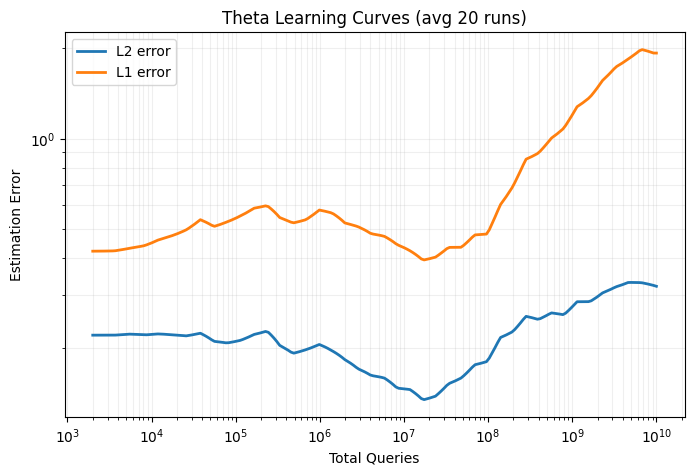

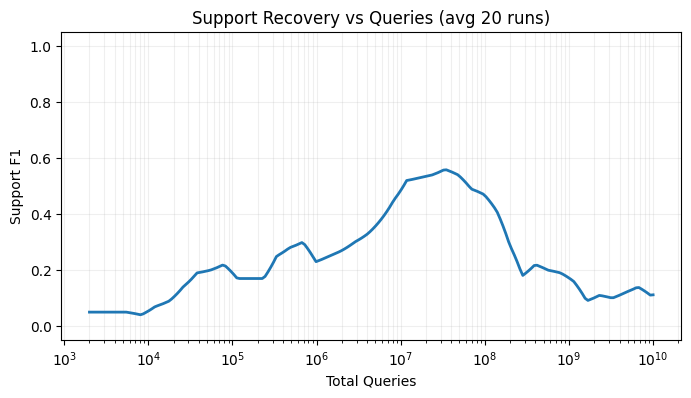

In [33]:

# Recommended: run with a threading backend (avoids joblib "remote worker" NameError issues in notebooks)
from joblib import parallel_backend

with parallel_backend("threading"):
    run_theta_learning_experiment(n_trials=20)
